# Implementing a MLP with Backpropagation

---



This lab will help you understand the concept of implementing a multi-layer perceptron using  backpropagation algorithm. You are free to use any ML library such as Tensorflow, PyTorch or any other. However, this lab is supported using PyTorch

Important Reference: To be able understand and code Deep Learning Models that are easy and ready for production one should seriously refer to the documentation and tutorial of [PyTorch](https://pytorch.org/tutorials/)

# MNIST Images - Our best friend!

The MNIST dataset is a large database of handwritten digits that is commonly used for training various image processing systems. The database is also widely used for training and testing in the field of machine learning. 

It consists of 60,000 training images and 10,000 testing images.

[MNIST Dataset](http://yann.lecun.com/exdb/mnist/)

![alt text](https://cdn-images-1.medium.com/max/1200/1*9Mjoc_J0JR294YwHGXwCeg.jpeg)

## Necesary libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data.dataloader as dataloader
import torch.optim as optim

from torch.utils.data import TensorDataset
from torchvision import transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt
import time

## Download the MNIST Train and Test set
Using the torch.utils.data DataLoader, we shuffle the data and set the batch size to be 256. It is very important for everyone to focus on how the dataloader works. Please refer to the documentation.

In [2]:
train = MNIST('./data', train=True, download=True, transform=transforms.ToTensor())

test = MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

cuda = torch.cuda.is_available()


dataloader_args = dict(shuffle=True, batch_size=256,num_workers=4, pin_memory=True) if cuda \
                        else dict(shuffle=True, batch_size=64)
train_loader = dataloader.DataLoader(train, **dataloader_args) 
# Complete the piece of code to load the test data
test_loader = dataloader.DataLoader(test, **dataloader_args)


## Compute basic data statistics
It is always important to know the shape of the data, as well as the min/max and mean/variance Print all the values. You may use the following functions in pytorch

Numpy Shape (train.train_data.cpu/gpu.numpy().shape), Tensor Shape (train_data_size), min (torch.min), max (torch.max), mean (torch.mean), variance (torch.var), standard deviation (torch.std)

In [3]:
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print("The Numpuy shape is: ", train_data.cpu().numpy().shape)
print("The Tensor shape is: ", train_data.size())
print("The min is: ", torch.min(train_data))
print("The max is: ", torch.max(train_data))
print("The mean is: ", torch.mean(train_data))
print("The variance is: ", torch.var(train_data))
print("The standard deviation is: ", torch.std(train_data))

C:\Users\yizhe\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


The Numpuy shape is:  (28, 60000, 28)
The Tensor shape is:  torch.Size([28, 60000, 28])
The min is:  tensor(0.)
The max is:  tensor(1.)
The mean is:  tensor(0.1306)
The variance is:  tensor(0.0949)
The standard deviation is:  tensor(0.3081)


## Visualize a few training samples
Using the matplotlib.pyplot library, we can visualize our input data.


C:\Users\yizhe\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


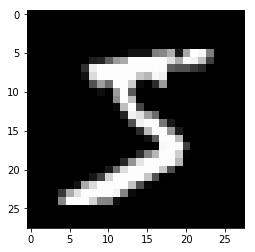

In [4]:
# Visualize a training instance with matplotlib
plt.imshow(train.train_data.cpu().numpy()[0], cmap='gray')

C:\Users\yizhe\Anaconda3\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


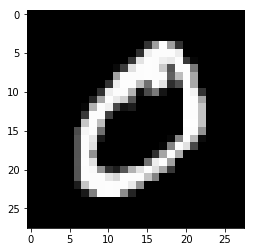

In [5]:
plt.imshow(train.train_data.cpu().numpy()[1], cmap='gray')

## Defining a Neural Network Model 

Define your model using the torch.nn.Module class

In [6]:
# SIMPLE MODEL DEFINITION
class Simple_MLP(nn.Module):
    def __init__(self, size_list):
        super(Simple_MLP, self).__init__()
        layers = []
        self.size_list = size_list
        for i in range(len(size_list) - 2):
            layers.append(nn.Linear(size_list[i],size_list[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(size_list[-2], size_list[-1]))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.size_list[0]) # Flatten the input
        return self.net(x)



## Create the model and define the Loss and Optimizer
You create an instance of the Simple_MLP model by passing it a list of layer sizes. The input layer contains 28*28 = 784 neurons. You may define a single hidden layer of size 256, and  output will be the class probabilities for each of the 10 digits (0-9).

How many neurons will be there in the output layer?

This is a classification task, I recommend you use Cross Entropy Loss (It is your error function or divergence function). We define our criterion using the torch.nn.CrossEntropyLoss.

In order to train our network, we use the torch.optim.SGD optimizer. You may use the optimizer **Adam**

In [7]:
# Please complete the code below Hint: Each comment is a line of code

# Create an instance of Simple MLP model
model = Simple_MLP([784,256,10])
# Specify the divergence function to use
criterion = torch.nn.CrossEntropyLoss()
# Print the model
print(model)
# Choose an optimizer for the model parameters (ex. optimizer = optim.Adam(model.parameters()))
optimizer = optim.Adam(model.parameters())
# You can use GPUs if your machineh has cuda dev = torch.device("cuda" if cuda else "cpu")
device = torch.device("cpu")

Simple_MLP(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


## Complete the function that will train the network for one epoch


In [8]:
def train_epoch(model, optimizer, train_loader, criterion):
    model.train()
    model.to(device)

    running_loss = 0.0
    
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   
        data = data.to(device)
        target = target.long().to(device)

        outputs = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

## A function that will evaluate your network's performance on the test set

In [9]:
def test_model(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        model.to(device)

        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0

        for batch_idx, (data, target) in enumerate(test_loader):   
            data = data.to(device)
            target = target.long().to(device)

            outputs = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(test_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc


## Train the model for N epochs
Call your train and test functions functions in a loop, while keeping track of the **losses and accuracy**.  You may write the code for 10 epochs. 

In [10]:
# Write your piece of code to run train and test the network for 10 epochs.  
n_epochs = 10
training_list = []
testing_list = []
for i in range(n_epochs):
    print("Epoch: ", i+1)
    training_list.append(train_epoch(model, optimizer, train_loader, criterion))
    testing_list.append(test_model(model, test_loader, criterion))
    print('\n')
    i += 1

Epoch:  1
Training Loss:  0.30114543208403627 Time:  10.684424877166748 s
Testing Loss:  0.16558020576170296
Testing Accuracy:  95.27 %


Epoch:  2
Training Loss:  0.12685322934296975 Time:  10.465675830841064 s
Testing Loss:  0.10938447607076092
Testing Accuracy:  96.88 %


Epoch:  3
Training Loss:  0.08380208300875384 Time:  10.59735655784607 s
Testing Loss:  0.08650226173269901
Testing Accuracy:  97.35000000000001 %


Epoch:  4
Training Loss:  0.060337858690596276 Time:  10.839963436126709 s
Testing Loss:  0.07352673655055511
Testing Accuracy:  97.77 %


Epoch:  5
Training Loss:  0.045850471286639286 Time:  10.750466346740723 s
Testing Loss:  0.07649570537410724
Testing Accuracy:  97.65 %


Epoch:  6
Training Loss:  0.03483333833305153 Time:  10.744397163391113 s
Testing Loss:  0.06891456488401267
Testing Accuracy:  97.91 %


Epoch:  7
Training Loss:  0.027320709310348894 Time:  11.646376609802246 s
Testing Loss:  0.07399808414944797
Testing Accuracy:  97.91 %


Epoch:  8
Training L

## Visualize Training Data. 

Draw a graph for Training Loss percentage with respect to number of epochs.

Text(0,0.5,'Percentage')

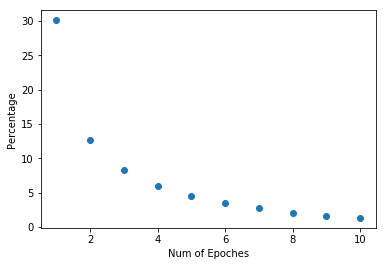

In [21]:
import matplotlib.pyplot as plt
# Insert your code here
training_loss = [x*100 for x in training_list]
epoches = list(range(1,11))
plt.scatter(epoches, training_loss)
plt.xlabel("Num of Epoches")
plt.ylabel("Percentage")

Draw a graph for Testing Loss percentage with respect to number of epochs. 

Text(0,0.5,'Percentage')

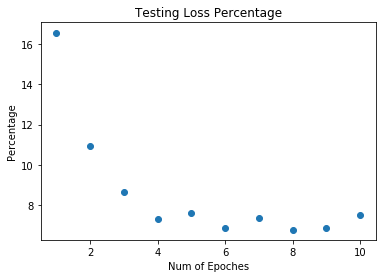

In [20]:
# Insert your code here
testing_collection = []
accuracy = []
for i in range(len(testing_list)):
    testing_collection.append(testing_list[i][0])
    accuracy.append(testing_list[i][1])
testing_loss = [x*100 for x in testing_collection]
plt.scatter(epoches, testing_loss)
plt.title("Testing Loss Percentage")
plt.xlabel("Num of Epoches")
plt.ylabel("Percentage")

Draw a graph for Accuracy  percentage with respect to number of epochs 

Text(0,0.5,'Percentage')

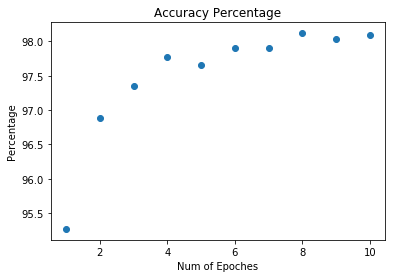

In [19]:
plt.scatter(epoches, accuracy)
plt.title("Accuracy Percentage")
plt.xlabel("Num of Epoches")
plt.ylabel("Percentage")